### Data downloaded from https://simplemaps.com/data/us-cities

In [92]:
import pandas as pd
import requests
import json 
import numpy as np
import matplotlib.pyplot as pl

In [226]:
import os
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point

### Finding driving distance
We use Open Source Routing Machine (OSRM) api to calculate this. 

http://project-osrm.org/docs/v5.24.0/api/?language=Python#general-options

In [119]:
def distance_between(loc1,loc2):

    """
    input:
        loc1: source location (long,lat)
        loc2: destination location (long,lat)
    output:
        distance: road distance in Km
        duration: time in mins
    """

    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{loc1[1]},{loc1[0]};{loc2[1]},{loc2[0]}?overview=false""")
    print(r.content)
    content = json.loads(r.content)['routes'][0]
    distance,duration = content['distance'],content['duration']

    return distance/1000, duration/60


In [123]:
loc1= (city_data.loc[city_data['city']=="Santa Barbara"][['lat','lng']]).values[0]
loc2 = (city_data.loc[city_data['city']=="Artesia"][['lat','lng']]).values[0]
print(loc1,loc2)
distance_between(loc1,loc2)

[  34.4285 -119.7202] [  33.8676 -118.0805]
b'{"code":"Ok","routes":[{"legs":[{"steps":[],"summary":"","weight":8458.4,"duration":8435.1,"distance":184368.5}],"weight_name":"routability","weight":8458.4,"duration":8435.1,"distance":184368.5}],"waypoints":[{"hint":"iYhsiv___38rAAAAMgAAAJAAAAAAAAAA9j6RQVu1LUCr-3BCAAAAACsAAAAyAAAAkAAAAAAAAACAXwAA_zbd-E9WDQL4Nt34VFYNAgUArwJGXy92","distance":0.849512506,"name":"","location":[-119.720193,34.428495]},{"hint":"6iXPhO0lz4TQAQAA1wMAAAAAAAAAAAAAKjrBQmXDTEMAAAAAAAAAAOcAAADsAQAAAAAAAAAAAACAXwAAhzz2-FHHBAIMPPb4UMcEAgAAPwtGXy92","distance":11.380486745,"name":"","location":[-118.080377,33.867601]}]}'


(184.3685, 140.585)

In [125]:
def get_city_data():
    final_file = 'cities_data/simplemaps_uscities_basicv1.76/uscitites_clean.csv'
    if os.path.isfile(final_file):
        with open(final_file,'rb') as f:
            data = pickle.load(f)
        return data
    
    file_name = 'cities_data/simplemaps_uscities_basicv1.76/uscities.csv'
    city_data = pd.read_csv(file_name)
    required_cols = ['city','state_id','state_name','county_name','lat','lng','population','density']
    city_data_filtered = city_data.filter(required_cols,axis=1)
    with open(final_file,'wb') as f:
        pickle.dump(city_data_filtered,f)
    return city_data_filtered

In [126]:
city_data = get_city_data()

In [139]:
city_data.head()

,city,state_id,state_name,county_name,lat,lng,population,density
0,New York,NY,New York,Queens,40.6943,-73.9249,18972871,10768.2
1,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
2,Chicago,IL,Illinois,Cook,41.8375,-87.6866,8595181,4576.6
3,Miami,FL,Florida,Miami-Dade,25.7840,-80.2101,5711945,4945.7
4,Dallas,TX,Texas,Dallas,32.7935,-96.7667,5668165,1522.2


### US state boundaries

In [229]:
STATE_NAME = 'California'
boundaries = pd.read_csv('cities_data/us-state-boundaries.csv',sep=';')
boundaries = boundaries.filter(['name','St Asgeojson'],axis=1)
boundaries.head()
state = json.loads((boundaries.loc[boundaries['name']==STATE_NAME]).values[0][1])
polygon = Polygon(state['coordinates'][0][0])

def state_grid(state_name,polygon,resolution):
    """creates grid of points inside the state

    Args:
        state_name: str of US state name   
        polygon (_type_): Polygon object for the state
        resolution: distance resolution for the grid (units of km)
    output:
        valid_points: list of (latitude,longitude) of points inside the state
    """
    ## Creating grid points inside the state
    x_min,y_min,x_max,y_max = polygon.bounds
    lat_dist_per_degree = 111 #in km
    long_dist_per_degree = np.cos((y_min+y_max)*0.5)*111 #km
    resolution_lat = resolution/lat_dist_per_degree
    resolution_long = resolution/long_dist_per_degree
    gridx_points = np.arange(x_min,x_max,resolution_long)
    gridy_points = np.arange(y_min,y_max,resolution_lat)
    # print(grid_points[0].flatten(),grid_points[1].flatten())
    valid_points = []
    invalid_points = []
    for x in gridx_points:
        for y in gridy_points:
            # print(Point(x,y).within(polygon))
            if Point(x,y).within(polygon):
                valid_points.append((x,y))
            else:
                invalid_points.append((x,y))
    return valid_points

In [227]:
CA_grid = 

In [223]:
## Creating grid points inside the state
x_min,y_min,x_max,y_max = polygon.bounds
lat_dist_per_degree = 111 #in km
long_dist_per_degree = np.cos((y_min+y_max)*0.5)*111 #km
resolution_dist = 10 #km
resolution_lat = resolution_dist/lat_dist_per_degree
resolution_long = resolution_dist/long_dist_per_degree
gridx_points = np.arange(x_min,x_max,resolution_long)
gridy_points = np.arange(y_min,y_max,resolution_lat)
# print(grid_points[0].flatten(),grid_points[1].flatten())
valid_points = []
invalid_points = []
for x in gridx_points:
    for y in gridy_points:
        # print(Point(x,y).within(polygon))
        if Point(x,y).within(polygon):
            valid_points.append((x,y))
        else:
            invalid_points.append((x,y))


In [225]:
len(valid_points)

4803

 ...]

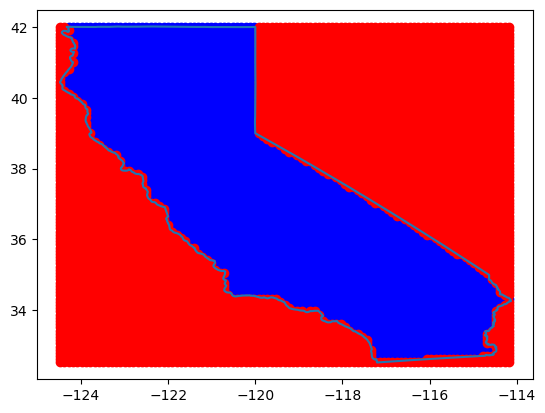

In [224]:
colors = ['blue','red']
pl.plot(*polygon.exterior.xy)
[pl.scatter(*p,color='blue') for p in valid_points]
[pl.scatter(*p,color='red') for p in invalid_points]

In [90]:
list(polygon.geometry.envelope.geometry.exterior[0].coords)

[(-124.482003000119, 32.5288320002052),
 (-114.131210999644, 32.5288320002052),
 (-114.131210999644, 42.0095030001829),
 (-124.482003000119, 42.0095030001829),
 (-124.482003000119, 32.5288320002052)]

In [85]:
type(CA_polygon)

shapely.geometry.polygon.Polygon